In [137]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
import re

In [138]:
from keras.layers import Input, Dropout, Dense, BatchNormalization, Activation, concatenate, LSTM, Embedding, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping#, TensorBoard
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam

## Reading Files

In [139]:
train=pd.read_csv("train.csv")
test=pd.read_csv('test.csv')

## Cleaning Data

In [140]:
stop_words=['about','above','after','again','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
def remove_punctuation(snt):
    return re.sub(r'[\W]',' ',snt.lower())

def remove_stop_words(sent):
    words = sent.split()
    resultwords=[word.lower() for word in words if word.lower() not in stop_words]
    return ' '.join(resultwords)

In [141]:
def clean_data():
    train.tweet=train.tweet.apply(remove_punctuation)
    test.tweet=test.tweet.apply(remove_punctuation)
    train.tweet=train.tweet.apply(remove_stop_words)
    test.tweet=test.tweet.apply(remove_stop_words)

In [142]:
clean_data()

## Tokenizing Text

In [143]:
text_data=np.hstack([train.tweet.str.lower(), 
                      test.tweet.str.lower()])
tok=Tokenizer()
tok.fit_on_texts(text_data)
print("   Transforming text to seq...")
train["input"] = tok.texts_to_sequences(train.tweet.str.lower())
test["input"] = tok.texts_to_sequences(test.tweet.str.lower())

   Transforming text to seq...


In [144]:
train.head()

,id,label,tweet,input
0,1,0,user when father is dysfunctional and is so se...,"[1, 35, 74, 11, 16982, 6, 11, 22, 3162, 70, 97..."
1,2,0,user user thanks for lyft credit can use cause...,"[1, 1, 163, 8, 7007, 2371, 32, 448, 671, 60, 6..."
2,3,0,bihday your majesty,"[61, 26, 3078]"
3,4,0,model love take with all the time in urð ð ð ð...,"[135, 14, 77, 17, 21, 3, 39, 7, 161, 2, 2, 2, ..."
4,5,0,factsguide society now motivation,"[3605, 1555, 48, 302]"


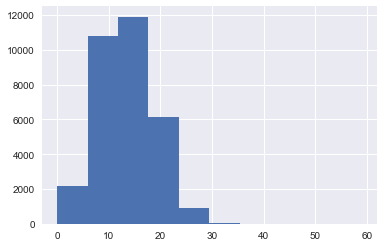

In [145]:
train.input.apply(lambda x: len(x)).hist()

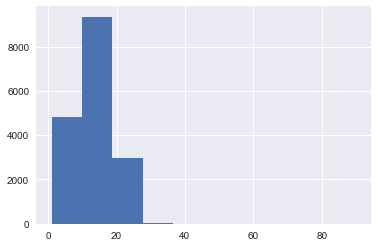

In [146]:
test.input.apply(lambda x: len(x)).hist()

In [147]:
MAX_LENGTH = 100
MAX_TOKEN = np.max([np.max(train.input.max()),np.max(test.input.max())]) + 5
print(MAX_LENGTH, MAX_TOKEN)

100 54065


## Seperating Training And Cross-Validation Sets And Encoding Labels

In [148]:
train.input.to_csv("train_data.csv",index=False)
test.input.to_csv("test_data.csv",index=False)

In [149]:
train_data=train[:-1000]
valid_data=train[-1000:]

In [150]:
train_x = pad_sequences(train_data.input, maxlen=MAX_LENGTH)
valid_x = pad_sequences(valid_data.input, maxlen=MAX_LENGTH)
train_y = np_utils.to_categorical(train_data.label.values, 2)
valid_y = np_utils.to_categorical(valid_data.label.values, 2)

## RNN-LSTM Model

In [167]:
A = Input(shape=[MAX_LENGTH], name="in")
B = Embedding(MAX_TOKEN, 256)(A)
C = LSTM(300) (B)
D = Dropout(0.6) (Dense(128, activation='relu') (C))
E = Dropout(0.4) (Dense(32, activation='relu') (D))
F = Dropout(0.4) (Dense(8, activation='relu') (E))
output = Dense(2, activation="softmax") (F)
model = Model(A, output)

In [ ]:
print(model.summary())
ad=Adam(0.001,decay=1e-6)
model.compile(optimizer=ad,loss='categorical_crossentropy',metrics = ['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              (None, 100)               0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 100, 256)          13840640  
_________________________________________________________________
lstm_11 (LSTM)               (None, 300)               668400    
_________________________________________________________________
dense_26 (Dense)             (None, 128)               38528     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 32)                4128      
_________________________________________________________________
dropout_16 (Dropout)         (None, 32)                0         
__________

## Training Data

In [ ]:
model.fit(train_x, train_y, batch_size = 128, epochs = 5, 
                verbose = 1, validation_data = (valid_x, valid_y))

Train on 30962 samples, validate on 1000 samples
Epoch 1/5
30962/30962 [==============================] - 572s - loss: 0.2569 - acc: 0.9232 - val_loss: 0.1177 - val_acc: 0.9610
Epoch 2/5
 9856/30962 [========>.....................] - ETA: 402s - loss: 0.1087 - acc: 0.9655

## Saving Model And Submitting Predictions 

In [165]:
test_x=pad_sequences(test.input, maxlen=MAX_LENGTH)
preds=model.predict(test_x)

In [156]:
 _model=model.to_json()
with open("Model__softmax_3.json","w") as json_file:
    json_file.write(_model)
model.save_weights("weights_softmax_3.h5")

In [157]:
with open("submission.csv",'w') as f:
    f.write('id,label\n')
    for i in range(len(test_x)):
        f.write('{},{}\n'.format(test.id[i],np.argmax(preds[i])))